# Cutmix or Mixup Augmentation 비교 실험하기

## 1. Augmentation을 적용한 데이터셋 만들기

 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [3]:
#GPU 환경 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
'stanford_dogs',
split=['train', 'test'],
shuffle_files=True,
with_info=True)

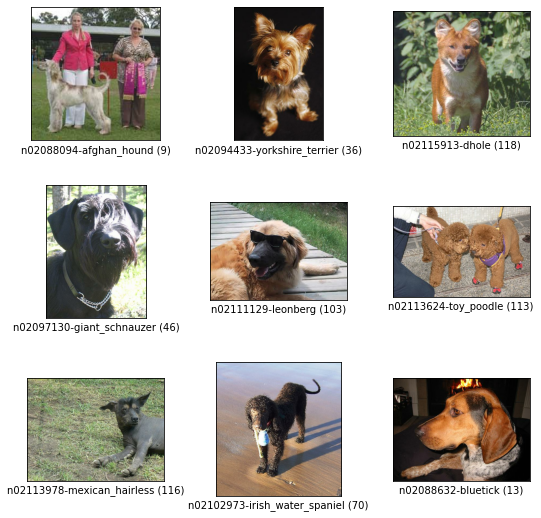

In [5]:
fig = tfds.show_examples(ds_train, ds_info)

In [6]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

In [7]:
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [8]:
def mix_2_label(label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

In [23]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
#     else:
#         ds = ds.map(
#             onehot,
#             num_parallel_calls=2
#         )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [19]:
import matplotlib.pyplot as plt

for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

In [11]:
no_aug_applied = apply_normalize_on_dataset(ds_train, with_cutmix=False)

In [12]:
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [24]:
cutmix_applied = apply_normalize_on_dataset(ds_train, with_cutmix=True)

In [26]:
num_classes = ds_info.features["label"].num_classes

## 2. 모델 만들기

비교실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.

In [27]:
resnet50 = keras.models.Sequential([
            keras.applications.resnet.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3),
            pooling='avg'),
        keras.layers.Dense(num_classes, activation='softmax')
])

In [28]:
aug_resnet50 = keras.models.Sequential([
                keras.applications.resnet.ResNet50(
                include_top=False,
                weights='imagenet',
                input_shape=(224, 224, 3),
                pooling='avg'),
            keras.layers.Dense(num_classes, activation='softmax')
])

## 3. 모델 훈련하기

모델을 훈련시켜 주세요.

In [34]:
EPOCH = 20

tf.random.set_seed(2020)

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'])

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'])

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=750,
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/20
750/750 [==============================] - 112s 149ms/step - loss: 0.0937 - accuracy: 0.9880 - val_loss: 1.0091 - val_accuracy: 0.7111
Epoch 2/20
750/750 [==============================] - 112s 150ms/step - loss: 0.0610 - accuracy: 0.9941 - val_loss: 0.9692 - val_accuracy: 0.7267
Epoch 3/20
750/750 [==============================] - 113s 150ms/step - loss: 0.0321 - accuracy: 0.9967 - val_loss: 0.9470 - val_accuracy: 0.7367
Epoch 4/20
750/750 [==============================] - 113s 150ms/step - loss: 0.0135 - accuracy: 0.9994 - val_loss: 0.9287 - val_accuracy: 0.7424
Epoch 5/20
750/750 [==============================] - 115s 154ms/step - loss: 0.0150 - accuracy: 0.9992 - val_loss: 0.9551 - val_accuracy: 0.7418
Epoch 6/20
750/750 [==============================] - 116s 155ms/step - loss: 0.0122 - accuracy: 0.9996 - val_loss: 0.9602 - val_accuracy: 0.7397
Epoch 7/20
750/750 [==============================] - 120s 161ms/step - loss: 0.0059 - accuracy: 0.9999 - val_loss: 0.9656 -

## 4. 훈련 과정 시각화하기


훈련 과정의 히스토리를 그래프로 시각화해 주세요.

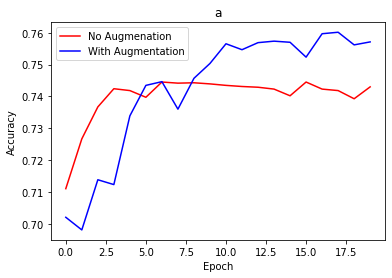

In [35]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('a')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmenation', 'With Augmentation'], loc='upper left')
plt.show()

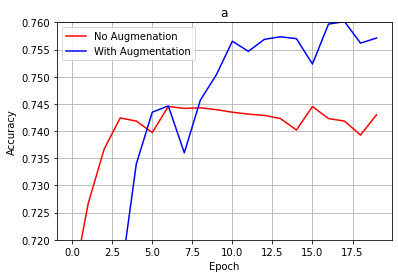

In [36]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('a')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmenation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)
plt.show()

## 5. Augmentation에 의한 모델 성능 비교

No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

 

# 회고:  
## 1. **이번 프로젝트에서 어려웠던 점**   
- Augmentation을 함수로 만들어 사용하고 코드를 이해하는데 어려움이 있었다.   
- Cutmix, Mixup의 방법을 이해하는데 어려움이 있었다.


## 2. **루브릭 평가 지표를 맞추기 위해 시도한 것들**   
1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?  
성공적으로 적용하였다. 
2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?   
다양한 실험을 진행하지 못했다.   
3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?
체계적으로 분석하지 못했다.
   
### 4. **만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정**   
원핫 벡터로 변환하는 함수가 문제가 있었다. 이미 앞에서 진행했던 부분인데 함수 안에 다시 들어가 있어서 찾아내고 해결하는데 어려움이 있었다.   
또 다른 Augmentation을 활용하여 비교해보지 못한게 아쉽다.
   
### 5. **자기 다짐**   
최근에 데이콘에서 진행하는 Post Estimation 공모전에 참가하였는데 데이터로 주어진 사진이 너무 적어 augmentatoin을 진행하였었는데 이번에 배운 데이터 증강을 활용하였으면 결과가 어땠을지 싶다. 그리고 라이브러리를 활용하여 더 쉽게 진행했다면 시간낭비를 많이 하지 않았을텐데 하는 아쉬움도 있다.   